In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from pathlib import Path
import pandas as pd
from keras.backend import tf as ktf
import sys
import cv2
import six

# keras
import keras
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler

from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras import backend as K
import math

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

ROOT_PATH = Path('/home/downloads/CarND-Behavioral-Cloning-P3/')
#ROOT_PATH=Path('/src')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#SAMPLE_DATA_PATH = ROOT_PATH/'data/sample_data'
SAMPLE_DATA_PATH = ROOT_PATH/'data/all'
print('tensorflow version: ', tf.__version__)
print('keras version: ', keras.__version__)
print('python version: ', sys.version_info)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3649399025200533814
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4876402688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15606470258675331603
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:1e:00.0, compute capability: 6.1"
]
tensorflow version:  1.8.0
keras version:  2.2.0
python version:  sys.version_info(major=3, minor=5, micro=5, releaselevel='final', serial=0)


In [2]:
logs = pd.DataFrame()
excluded_folders = [
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2-20180706.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-2.csv',
    #'/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2_20180707.csv',
    #'/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2-20180707-2.csv',
    #'/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-20180709-path2-2.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-track1-drive.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-track1-recovery.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path1-20180706.csv',
    #'/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2-20180709.csv',
    #'/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2-20180709-3.csv'
]
for log_file in SAMPLE_DATA_PATH.glob('*.csv'):
    if str(log_file) in excluded_folders:
        continue
    print(log_file)
    one_log = pd.read_csv(log_file)
    logs = pd.concat([logs, one_log], axis=0)
logs.tail()

/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-20180709-path2-2.csv
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2-20180707-2.csv
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2_20180707.csv
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2-20180709-3.csv
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-path2-20180709.csv


,center,left,right,steering,throttle,brake,speed
5460,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,0.0,1.0,0.0,30.19026
5461,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,0.0,1.0,0.0,30.19037
5462,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,0.0,1.0,0.0,30.19032
5463,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,0.0,1.0,0.0,30.19039
5464,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,/Users/jiangtao/Downloads/path2_20180709_curve...,0.0,1.0,0.0,28.68811


In [3]:
IMG_FOLDER_PATH = SAMPLE_DATA_PATH/'IMG'

def get_img_files(img_folder_path):
    image_files = []
    labels = dict()
    correction = 0.2

    for log in logs.iterrows():
        center, left, right, y = log[1][:4]
        for i, img_path in enumerate([center, left, right]):
            img_path = img_path.split('/')[-1].strip()
            abs_img_path = str(img_folder_path/img_path)
            if i == 1:
                y_corrected = y + correction # left
            elif i == 2:
                y_corrected = y - correction # right
            else:
                y_corrected = y

            image_files.append(abs_img_path)
            labels[abs_img_path] = y_corrected

    np.random.shuffle(image_files)
    trn_end_idx = int(len(image_files)*0.8)
    
    train_img_files = image_files[:trn_end_idx]
    val_img_files = image_files[trn_end_idx:]
    
    return train_img_files, val_img_files, labels

In [4]:
TRAIN_IMG_FILES, VAL_IMG_FILES, LABELS = get_img_files(IMG_FOLDER_PATH)

In [5]:
len(TRAIN_IMG_FILES), len(VAL_IMG_FILES), len(LABELS.keys())

(66446, 16612, 83058)

In [6]:
def preprocess(img):
    # resize to half height and width
    img = resize(img, (80, 160, 3), anti_aliasing=True, mode='constant')
    return img

def augment_data(img, y, probs=0.5):
    # flip
    if np.random.rand() > probs:
        img = np.fliplr(img)
        y = -y
    return img, y

In [7]:
# adpated from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
class GeneratorFromFiles(keras.utils.Sequence):
    '''Generate data from list of image files.'''
    
    def __init__(self, list_files, labels, batch_size=64,
                 dim=(160, 320, 3),
                 post_dim=(80, 160, 3),
                 shuffle=True, 
                 data_aug=None,
                 resize=False):
        '''
        Paramters
        ----------
        list_files : a list of absolute path to image files
        labels : a dictionary mapping image files to labels (classes/continous value)
        batch_size : size for each batch
        dim : dimension for input image, height x width x number of channel
        shuffle : whether to shuffle data at each epoch
        '''
        self.dim = dim
        self.post_dim = post_dim
        self.batch_size = batch_size
        self.list_files = list_files
        self.labels = labels
        self.shuffle = shuffle
        self.data_aug = data_aug
        self.resize=resize
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(len(self.list_files) / self.batch_size)
    
    def __getitem__(self, index):
        # generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # find list of files
        list_files_batch = [self.list_files[k] for k in indexes]
        X, ys = self._generate(list_files_batch, self.data_aug)
        
        return X, ys
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def _generate(self, list_files_batch, data_aug=None):
        X = np.zeros((self.batch_size, ) + self.post_dim)
        ys = np.zeros((self.batch_size))
        
        for i, img_file in enumerate(list_files_batch):
            x = plt.imread(img_file)
            if self.resize:
                x = cv2.resize(x, None, fx=0.5, fy=0.5)
            y = self.labels[img_file]
            if data_aug is not None:
                x, y = data_aug(x, y)
            X[i, ] = x
            ys[i] = y
        
        return X, ys

Visualize flipping the image

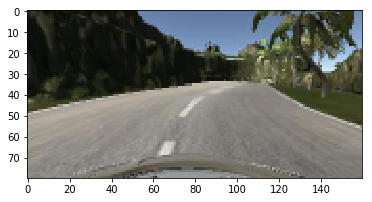

In [8]:
data_generator = GeneratorFromFiles(TRAIN_IMG_FILES, LABELS, resize=True)
res = next(iter(data_generator))
plt.imshow(res[0][56].astype(int))

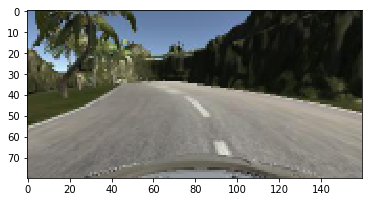

In [9]:
plt.imshow(augment_data(res[0][56], res[1][60], 0.0)[0].astype(int))

### Nvidia model

best architecture as of 20180706
```python
in_shape = (160, 320, 3)
dropout_rate = 0.05
model = Sequential()
#model.add(Lambda(lambda image: keras.backend.tf.image.resize_images(image, (80, 160)), input_shape=(in_shape)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(in_shape)))
model.add(Conv2D(24, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(36, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(48, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, (3, 3), strides=(1,1), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, (3, 3), strides=(1,1), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(100, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(50, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

opt = Adam(lr=1e-4)
model.compile(loss='mse', optimizer=opt)
```

`model-nvidia-ver2.h5`
```
839/839 [==============================] - 183s 218ms/step - loss: 0.0807 - val_loss: 0.0388
Epoch 2/5
839/839 [==============================] - 178s 212ms/step - loss: 0.0421 - val_loss: 0.0364
Epoch 3/5
839/839 [==============================] - 178s 212ms/step - loss: 0.0358 - val_loss: 0.0337
Epoch 4/5
839/839 [==============================] - 180s 215ms/step - loss: 0.0316 - val_loss: 0.0294
Epoch 5/5
839/839 [==============================] - 180s 215ms/step - loss: 0.0282 - val_loss: 0.0275
```

In [10]:
CHANNEL_AXIS = 2

def _bn_relu_dropout(input, dropout_rate):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    relu = Activation('relu')(norm)
    return Dropout(dropout_rate)(relu)
 

def _conv_bn_relu_dropout(**conv_params):
    '''Helper to build a conv -> BN -> relu block -> dropout
    '''
    filters = conv_params['filters']
    kernel_size = conv_params['kernel_size']
    strides = conv_params.setdefault('strides', (1, 1))
    kernel_initializer = conv_params.setdefault('kernel_initializer', 'he_normal')
    padding = conv_params.setdefault('padding', 'valid')
    kernel_regularizer = conv_params.setdefault('kernel_regularizer', l2(1.e-4))
    dropout_rate = conv_params.setdefault('dropout_rate', 0.1)

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu_dropout(conv, dropout_rate)

    return f    

def _dense_dropout(input, n, dropout_rate):
    return Dropout(dropout_rate)(Dense(n, activation='relu')(input))

def build_nvidia(in_shape, num_outputs, dropout_rate):
    input = Input(shape=in_shape)
    in_layer = Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(in_shape))(input)
    in_layer = _conv_bn_relu_dropout(filters=24, kernel_size=(5, 5), strides=(2, 2), dropout_rate=dropout_rate)(in_layer)
    in_layer = _conv_bn_relu_dropout(filters=36, kernel_size=(5, 5), strides=(2, 2), dropout_rate=dropout_rate)(in_layer)
    in_layer = _conv_bn_relu_dropout(filters=48, kernel_size=(5, 5), strides=(2, 2), dropout_rate=dropout_rate)(in_layer)
    in_layer = _conv_bn_relu_dropout(filters=64, kernel_size=(3, 3), strides=(1, 1), dropout_rate=dropout_rate)(in_layer)
    in_layer = _conv_bn_relu_dropout(filters=64, kernel_size=(3, 3), strides=(1, 1), dropout_rate=dropout_rate)(in_layer)

    flatten = Flatten()(in_layer)
    flatten = _dense_dropout(flatten, 1024, dropout_rate)
    flatten = _dense_dropout(flatten, 128, dropout_rate)
    flatten = _dense_dropout(flatten, 64, dropout_rate)
    dense = Dense(units=num_outputs)(flatten)

    model = Model(inputs=input, outputs=dense)
    return model

In [11]:
#in_shape = (160, 320, 3)
in_shape = (80, 160, 3)
dropout_rate = 0.1
model = build_nvidia(in_shape, 1, dropout_rate)

In [12]:
opt = Adam(lr=5e-4)
model.compile(loss='mse', optimizer=opt)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 160, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 78, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 78, 24)        312       
_________________________________________________________________
activation_1 (Activation)    (None, 38, 78, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 78, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 37, 36)        21636     
__________

### ResNet

In [31]:
L2_RATE = 1e-4

def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(L2_RATE))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(L2_RATE))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(L2_RATE))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        #block_shape = K.int_shape(block)
        #pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]), strides=(1, 1))(block)
        flatten1 = Flatten()(block)
        dense = Dense(1024)(flatten1)
        dense = Dense(256)(dense)
        dense = Dense(64)(dense)
        dense = Dense(units=num_outputs)(dense)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

In [32]:
#in_shape = (160, 320, 3)
in_shape = (80, 160, 3)
model = ResnetBuilder.build_resnet_18(in_shape, 1)

In [37]:
opt = Adam(lr=5e-5)
model.compile(loss='mse', optimizer=opt)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 80, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 40, 80, 64)   9472        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 40, 80, 64)   256         conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation_91 (Activation)      (None, 40, 80, 64)   0           batch_normalization_91[0][0]     
__________________________________________________________________________________________________
max_poolin

In [38]:
%%time
trn_data_generator = GeneratorFromFiles(TRAIN_IMG_FILES, LABELS, resize=True)
val_data_generator = GeneratorFromFiles(VAL_IMG_FILES, LABELS, resize=True)

model.fit_generator(trn_data_generator, 
                    validation_data=val_data_generator, 
                    epochs=10, 
                    workers=2,
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/10
1038/1038 [==============================] - 111s 107ms/step - loss: 0.7517 - val_loss: 0.6717
Epoch 2/10
1038/1038 [==============================] - 102s 98ms/step - loss: 0.6064 - val_loss: 0.5548
Epoch 3/10
1038/1038 [==============================] - 107s 103ms/step - loss: 0.5095 - val_loss: 0.4813
Epoch 4/10
1037/1038 [============================>.] - ETA: 0s - loss: 0.4414

Process ForkPoolWorker-53:
Process ForkPoolWorker-52:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = 

KeyboardInterrupt: 

In [35]:
opt = Adam(lr=2e-5)
model.compile(loss='mse', optimizer=opt)

In [36]:
%%time
model.fit_generator(trn_data_generator, 
                    validation_data=val_data_generator, 
                    epochs=5, 
                    workers=2,
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/5
 844/1038 [=======================>......] - ETA: 16s - loss: 0.9194

Process ForkPoolWorker-28:
Traceback (most recent call last):
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/queues.py", line 341, in put
    obj = ForkingPickler.dumps(obj)
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/reduction.py", line 50, in dumps
    cls(buf, protocol).dump(obj)
KeyboardInterrupt


KeyboardInterrupt: 

Process ForkPoolWorker-29:
Traceback (most recent call last):
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/user/miniconda/envs/py35/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [18]:
model.save(ROOT_PATH/'models/model-resnet-1.h5', include_optimizer=False)